# Modeling and Conclusion

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier # RandomForest Model
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.pipeline import Pipeline # Pipleline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score,plot_roc_curve, roc_auc_score # Classification Metric

## Reading the data

In [2]:
data = pd.read_csv('../data/reddit_data_clean.csv')

In [3]:
data.head()

,title,subreddit,clean_title,cat_subreddit,word_count,character_count
0,NAKD becoming EV company,StockMarket,nakd becoming ev company,1,4,24
1,Biotech Due Diligence,StockMarket,biotech due diligence,1,3,21
2,IREN,StockMarket,iren,1,1,4
3,Beginner- can someone explain why IREN is perf...,StockMarket,beginner can someone explain why iren is perfo...,1,12,74
4,trading site,StockMarket,trading site,1,2,12


## Preprocessing

##### _Checking the data again to see if any `NaN` which will impact our modeling process._

In [4]:
data.dropna(inplace = True)

In [5]:
data.isnull().sum()

title              0
subreddit          0
clean_title        0
cat_subreddit      0
word_count         0
character_count    0
dtype: int64

In [6]:
data.shape

(3188, 6)

#### _Set up features and predicted value `y`_

In [7]:
X = data['clean_title']

In [8]:
y = data['cat_subreddit']

#### Baseline Accuracy

In [9]:
y.value_counts(normalize = True) # baseline accuracy

1    0.623902
0    0.376098
Name: cat_subreddit, dtype: float64

##### _The baseline accuracy is very important as it provides a metric for us to compare with future models._

#### Train Test Split

In [10]:
X_train, X_test, y_train, y_test =train_test_split(X,
                                                   y,
                                                   test_size=0.33,
                                                   stratify=y,
                                                   random_state=42
                                                  )

##### _Splitting data into `train` and `test`. `train` data will be used to initiate the model and `test` data will be used to test how the model performs._

## Modeling

#### CountVectorizer with RandomForest Classifier

#### _Setting up pipeline_

In [11]:
pipe_cvec_random = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf' , RandomForestClassifier())
])

pipe_parames_cvec_random = {
    'cvec__max_features': [None, 2000, 3000, 5000], # CountVectorizer Hyperparameters
    'cvec__min_df': [1,2,3],
    'cvec__max_df': [.85,.90, .95],
    'cvec__stop_words': [None,'english'],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200], # RandomForest Hyperparameters
    'rf__max_depth': [None, 1, 2, 3, 4, 5]
}


#### _GridSearch_

In [12]:
gs_rf = GridSearchCV(pipe_cvec_random, param_grid=pipe_parames_cvec_random, cv=5, n_jobs=6)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [None, 2000, 3000, 5000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'rf__max_depth': [None, 1, 2, 3, 4, 5],
                         'rf__n_estimators': [100, 150, 200]})

#### _Scores_

In [13]:
gs_rf.best_score_

0.8669789227166277

In [14]:
gs_rf.score(X_train, y_train) # Train

0.9911007025761124

In [15]:
gs_rf.score(X_test,y_test) # Test

0.8395061728395061

In [16]:
gs_rf.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'rf__max_depth': None,
 'rf__n_estimators': 150}

##### _The scores are a indicator of how the model is working on `train` and `test` dataset. With accuracy dropped in `test` data, it demonstrated the model is overfitting. Additionally, the best hyperparameter that we have `GridSearch` on are also listed above._

In [17]:
pred_rf = gs_rf.predict(X_test)

#### _Random Forest Evaluation & Metrics_

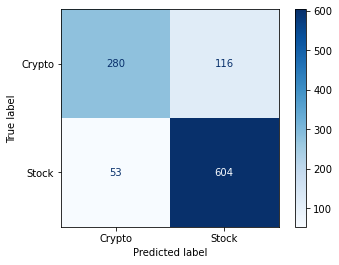

In [18]:
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Blues', 
                      values_format='d',display_labels=['Crypto', 'Stock'])
plt.show()

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_rf).ravel()
specificity = tn / (tn+fp)

In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_rf).ravel()
specificity_rf = tn / (tn+fp)

In [21]:
print (f'Accuracy Score:{accuracy_score(y_test, pred_rf)}')
print (f'Sensitivity Score:{recall_score(y_test, pred_rf)}')
print (f'Precision Score:{precision_score(y_test, pred_rf)}')
print (f'Specificity Score:{specificity_rf}')

Accuracy Score:0.8395061728395061
Sensitivity Score:0.9193302891933028
Precision Score:0.8388888888888889
Specificity Score:0.7070707070707071


#### CountVectorizer with Logistic Regression Classifier

#### _Setting up pipeline_

In [22]:
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params_cvec_lr = {
    'cvec__max_features': [None, 2000, 5000], # CountVectorizer Hyperparameters
    'cvec__min_df': [1,2,3],
    'cvec__max_df': [.85, .90, .95],
    'cvec__stop_words': [None,'english'],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None,'english'],
    'lr__penalty': [None, 'l2']
}

#### _GridSearch_

In [23]:
gs_lr = GridSearchCV(pipe_cvec_lr, param_grid=pipe_params_cvec_lr, cv=5,n_jobs = 8)
gs_lr.fit(X_train,y_train)

/Users/jay/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.84964871        nan 0.86135831        nan 0.84309133
        nan 0.85667447        nan 0.84355972        nan 0.85901639
        nan 0.84309133        nan 0.85995316        nan 0.84074941
        nan 0.85854801        nan 0.84074941        nan 0.85854801
        nan 0.84637002        nan 0.86135831        nan 0.84215457
        nan 0.85948478        nan 0.84355972        nan 0.85901639
        nan 0.84309133        nan 0.85995316        nan 0.84074941
        nan 0.85854801        nan 0.84074941        nan 0.85854801
        nan 0.84964871        nan 0.86135831        nan 0.84543326
        nan 0.86088993        nan 0.84355972        nan 0.85901639
        nan 0.84309133        nan 0.85995316        nan 0.84074941
        nan 0.85854801        nan 0.84074941        nan 0.85854801
        nan 0.84964871        nan 0.8613583

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [None, 2000, 5000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__penalty': [None, 'l2']})

#### _Scores_

In [24]:
gs_lr.score(X_train, y_train) # Train

0.9648711943793911

In [25]:
gs_lr.score(X_test, y_test) # Test

0.8490028490028491

In [26]:
gs_lr.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'lr__penalty': 'l2'}

##### _Same as Random Forest Model, scores are a indicator of how the model is working on `train` and `test` dataset. Even the gap between `train` and `test` are smaller, but still a indication of overfitting. Additionally, the best hyperparameter that we have `GridSearch` on are also listed above._

In [27]:
pred_lr = gs_lr.predict(X_test)

#### _Logistic Regression Evaluation & Metrics_

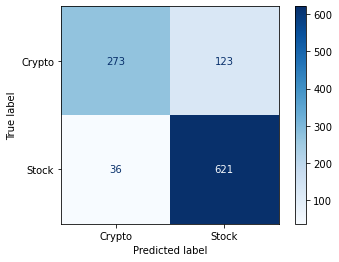

In [28]:
plot_confusion_matrix(gs_lr, X_test, y_test, cmap='Blues', 
                      values_format='d',display_labels=['Crypto', 'Stock'])
plt.show()

In [29]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_lr).ravel()
specificity = tn / (tn+fp)

In [30]:
print (f'Accuracy Score:{accuracy_score(y_test, pred_lr)}')
print (f'Sensitivity Score:{recall_score(y_test, pred_lr)}')
print (f'Precision Score:{precision_score(y_test, pred_lr)}')
print (f'Specificity Score:{specificity}')

Accuracy Score:0.8490028490028491
Sensitivity Score:0.9452054794520548
Precision Score:0.8346774193548387
Specificity Score:0.6893939393939394


## Model Evaluations

#### _Metrics Summary_

|  | Random Forest | Logistic Regression |
|---|---|---|
| Accuracy Score | 0.840 | 0.850 |
| Sensitivity Score | 0.920 | 0.945 |
| Precision Score | 0.839 | 0.835 |
| Specificity | 0.707 | 0.690 |

##### _Just based on the `Accuracy Score`, we can conclude, the `Logistic Regression` Model performed better._

#### _`ROC` Curve Comparison_

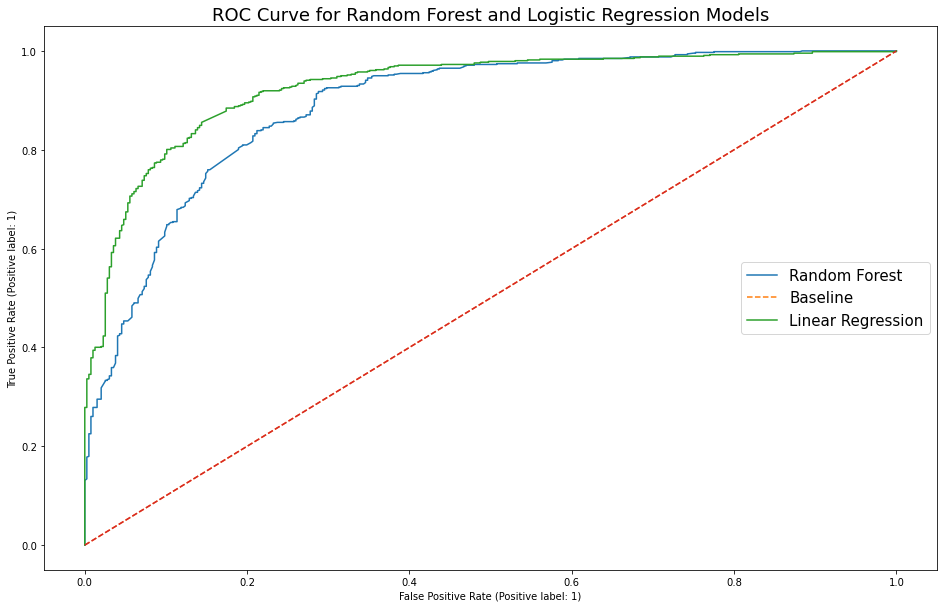

In [31]:
classifiers = [gs_rf, gs_lr]
fig, ax = plt.subplots(figsize=(16, 10))
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)
    plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")
    plt.legend(loc='center right', labels=['Random Forest', 'Baseline', 'Linear Regression'],fontsize=15, title_fontsize=20)
    plt.title ('ROC Curve for Random Forest and Logistic Regression Models', fontsize = 18)
    plt.savefig('../image/roc_curve')

##### _The `ROC` curve provide a visualization to compare the two models.It shows the trade-off between Sensitivity and Specificity. In general, our models that give curves closer to the top-left corner indicates a better performance. The dotted line is the baseline where the Sensitivity equals to Specificity. In another word, the closer the curves get to the baseline the less accurate the model._ 

#### _Model Prediction Comparison_

In [32]:
pred_lr = gs_lr.predict(X_test)

In [33]:
data_com = data.loc[X_test.index]

In [34]:
data_com['predicted_outcome'] = pred_lr

In [35]:
pd.set_option('display.max_colwidth', 0)

In [39]:
data_com.loc[data_com['cat_subreddit'] != data_com['predicted_outcome']].sample(1, random_state=20)

,title,subreddit,clean_title,cat_subreddit,word_count,character_count,predicted_outcome
3068,Anyone Heard of Notional Finance ($NOTE)?,CryptoCurrency,anyone heard of notional finance note,0,6,37,1


In [37]:
data_com.loc[data_com['cat_subreddit'] == data_com['predicted_outcome']].sample(1, random_state = 5)

,title,subreddit,clean_title,cat_subreddit,word_count,character_count,predicted_outcome
443,"Finally made it to $51,000 in my main brokerage account! Broke out to all time highs, mainly due to my options trading this month. Gotta love untaxed gains and NVDA calls 🚀😈",StockMarket,finally made it to 51000 in my main brokerage account broke out to all time highs mainly due to my options trading this month got to love untaxed gains and nvda calls,1,32,167,1


##### _Based on the `ROC` curve and different classification metric, the Logistic Regression Model has a better outcome on accurately predicts subreddit based on title text. However, we also want to know more insight about the Logistic Regression. The above two table shows the scenarios when the model correctly predicts the outcome and incorrectly predicts the outcome.In general, the model predicts correctly, when the text contains some defining words like `options`. On the other hand, the incorrect predicted subreddit is a more general text that doesn't contains signature features to differentiate._

## Conclusions and Recommendations
_In this project we have built two models, Random Forest and Logistic Regression with CountVecorizer. Overall, both model performed better than our baseline accuracy of 62.4%._

_We can observe both of the models shows varies degrees of **overfittings**. Based on the basic metric of accuracy, **Logistic Regression with CountVectorizer perform better in this project.**_

_As recommending the Logistic Regression model to a Crypto Currency trading software companies to post software advertisement, it is also important to evaluate some other metrics like Sensitivity. **Sensitivity scores** explains among those CryptoCurrency subreddit, how many did the model predict correctly. For Random Forest Model, the sensitivity score is 92.0%. On the other hand, the Logistic Regression has a 94.5% sensitivity scores. Logistic Regression model performed much better than the Random Forest Model. Specifically, as the software company is targeting potential consumers, high sensitivity rate will allow the company target more direct consumers correctly for its Crypto Currency software._


_For future improvement to the model, the following steps can be considered:_ 
- _In the EDA part, we have found some words can be lemmatized such as Stock vs Stocks. Therefore, more deep cleaning to the original data can be done before modeling._ 
- _As`StockMarket` and `CryptoCurrency` are very closed topics, there are lots of overlapping words that appears in both subreddit. To better fit our model, we can consider remove these word to reduce some noise in our model._
- _Additionally, we might need to start considering emojis in our model. There are some certain emojis may help to differentiate posts. Based on the source, some emoji patterns are being used for Cryptocurrency for different subject. ([Source](https://www.blockchaincenter.net/crypto-emoji-cheat-sheet/))_